<a href="https://colab.research.google.com/github/causa0sui/dw_matrix_road_sign/blob/master/day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

from hyperopt import hp, STATUS_OK, tpe, Trials, fmin

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign


In [0]:
train = pd.read_pickle("data/train.p")
test = pd.read_pickle("data/test.p")

X_train, y_train = train["features"], train["labels"]
X_test, y_test = test["features"], test["labels"]

In [0]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [0]:
 input_shape = X_train.shape[1:]
 num_classes = y_train.shape[1]

In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size = (3, 3), activation='relu', input_shape = input_shape),

    Flatten(),

    Dense(num_classes, activation='softmax'),
])


def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

  logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(
      X_train, 
      y_train,
      batch_size = params_fit.get('batch_size', 128),
      epochs = params_fit.get('epochs', 5),
      verbose = params_fit.get('verbose', 1),
      validation_data = params_fit.get('validation_data', (X_train, y_train)),
      callbacks = [tensorboard_callback]
      )
  return model

In [0]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 7s 24ms/step - loss: 31.0908 - accuracy: 0.7061 - val_loss: 0.2931 - val_accuracy: 0.9314
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2477 - accuracy: 0.9412 - val_loss: 0.1696 - val_accuracy: 0.9563
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1477 - accuracy: 0.9649 - val_loss: 0.1244 - val_accuracy: 0.9712
Epoch 4/5
272/272 [==============================] - 6s 24ms/step - loss: 0.1151 - accuracy: 0.9728 - val_loss: 0.1119 - val_accuracy: 0.9755
Epoch 5/5
272/272 [==============================] - 7s 24ms/step - loss: 0.1068 - accuracy: 0.9759 - val_loss: 0.1088 - val_accuracy: 0.9738


In [0]:
df = pd.read_csv("data/signnames.csv")
labels_dict = df.to_dict()['b']


In [0]:
def predict(model_trained, X_test, y_test, scoring = accuracy_score):

  y_test_norm = np.argmax(y_test, axis = 1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis = 1)

  return scoring(y_test_norm, y_pred)


In [0]:
predict(model_trained, X_test, y_test)

0.8235827664399092

In [0]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [0]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size = (3, 3), activation='relu', input_shape = input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size = (3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),
])



train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 7s 24ms/step - loss: 3.6873 - accuracy: 0.4596 - val_loss: 0.5232 - val_accuracy: 0.8820
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.6798 - accuracy: 0.8004 - val_loss: 0.1784 - val_accuracy: 0.9603
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.3931 - accuracy: 0.8848 - val_loss: 0.0974 - val_accuracy: 0.9800
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2837 - accuracy: 0.9151 - val_loss: 0.0661 - val_accuracy: 0.9877
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2274 - accuracy: 0.9331 - val_loss: 0.0414 - val_accuracy: 0.9917


0.9310657596371882

In [0]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size = (3, 3), activation='relu', input_shape = input_shape),
    Conv2D(filters=32, kernel_size = (3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size = (3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size = (3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),
])



train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 10s 37ms/step - loss: 2.6305 - accuracy: 0.4482 - val_loss: 0.6651 - val_accuracy: 0.8418
Epoch 2/5
272/272 [==============================] - 10s 35ms/step - loss: 0.8436 - accuracy: 0.7461 - val_loss: 0.2442 - val_accuracy: 0.9409
Epoch 3/5
272/272 [==============================] - 10s 36ms/step - loss: 0.4433 - accuracy: 0.8652 - val_loss: 0.1228 - val_accuracy: 0.9735
Epoch 4/5
272/272 [==============================] - 10s 36ms/step - loss: 0.2502 - accuracy: 0.9252 - val_loss: 0.0514 - val_accuracy: 0.9875
Epoch 5/5
272/272 [==============================] - 10s 36ms/step - loss: 0.1861 - accuracy: 0.9449 - val_loss: 0.0434 - val_accuracy: 0.9895


0.9566893424036281

In [0]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size = (3, 3), activation='relu', input_shape = input_shape),
    Conv2D(filters=32, kernel_size = (3, 3), activation='relu', padding = 'same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size = (3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=64, kernel_size = (3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size = (3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=64, kernel_size = (3, 3), activation='relu'),
    #MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),
])

#get_cnn_v4(input_shape, num_classes).summary()

#train_and_predict(get_cnn_v4(input_shape, num_classes))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)         

0.9820861678004535

In [0]:
X_train[0].shape

(32, 32, 3)

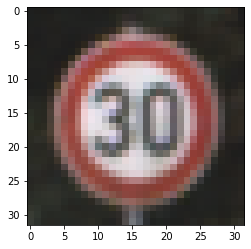

In [0]:
plt.imshow(X_test[500])

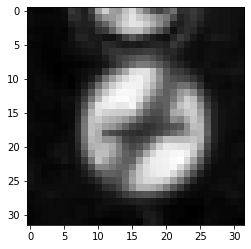

In [0]:
plt.imshow(color.rgb2gray(X_train[0]), cmap = plt.get_cmap('gray'))

In [0]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [0]:
model = get_cnn_v4((32,32,1), num_classes)
#model.compile(loss = 'crossenthropy', optimizer = 'Adam', metrics = ['accuracy'])
model_trained = train_model(model, X_train_gray, y_train, params_fit = {})
predict(model_trained, X_test_gray, y_test) #4 dzień

Epoch 1/5
272/272 [==============================] - 12s 45ms/step - loss: 1.7512 - accuracy: 0.5125 - val_loss: 0.1982 - val_accuracy: 0.9427
Epoch 2/5
272/272 [==============================] - 12s 44ms/step - loss: 0.2601 - accuracy: 0.9194 - val_loss: 0.0563 - val_accuracy: 0.9856
Epoch 3/5
272/272 [==============================] - 12s 44ms/step - loss: 0.1393 - accuracy: 0.9577 - val_loss: 0.0391 - val_accuracy: 0.9889
Epoch 4/5
272/272 [==============================] - 12s 44ms/step - loss: 0.1002 - accuracy: 0.9690 - val_loss: 0.0256 - val_accuracy: 0.9934
Epoch 5/5
272/272 [==============================] - 12s 44ms/step - loss: 0.0741 - accuracy: 0.9768 - val_loss: 0.0127 - val_accuracy: 0.9964


0.9662131519274376

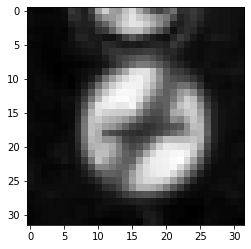

In [0]:
plt.imshow(color.rgb2gray(X_train[0]), cmap = plt.get_cmap('gray'))

In [0]:
#%tensorboard --logdir logs

Launching TensorBoard...

KeyboardInterrupt: ignored

In [0]:
# model = get_cnn_v2(input_shape, num_classes)
# params_fit = {
#     'epochs': 25
# }
# train_model(model, X_train, y_train, params_fit)

In [0]:
# %tensorboard --logdir logs

In [0]:
model = get_cnn_v4(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train, params_fit = {})

predict(model_trained, X_test, y_test)

Epoch 1/5
272/272 [==============================] - 12s 45ms/step - loss: 2.3022 - accuracy: 0.3907 - val_loss: 0.5756 - val_accuracy: 0.8533
Epoch 2/5
272/272 [==============================] - 12s 43ms/step - loss: 0.5836 - accuracy: 0.8207 - val_loss: 0.1424 - val_accuracy: 0.9637
Epoch 3/5
272/272 [==============================] - 12s 44ms/step - loss: 0.2796 - accuracy: 0.9147 - val_loss: 0.0708 - val_accuracy: 0.9824
Epoch 4/5
272/272 [==============================] - 12s 44ms/step - loss: 0.1811 - accuracy: 0.9447 - val_loss: 0.0285 - val_accuracy: 0.9920
Epoch 5/5
272/272 [==============================] - 12s 44ms/step - loss: 0.1265 - accuracy: 0.9620 - val_loss: 0.0247 - val_accuracy: 0.9941


0.973015873015873

In [0]:
def get_model(params):
  return Sequential([
    Conv2D(filters=32, kernel_size = (3, 3), activation='relu', input_shape = input_shape),
    Conv2D(filters=32, kernel_size = (3, 3), activation='relu', padding = 'same'),
    MaxPool2D(),
    Dropout(params['dropout_cnn_block_one']),

    Conv2D(filters=64, kernel_size = (3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=64, kernel_size = (3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(params['dropout_cnn_block_two']),

    Conv2D(filters=128, kernel_size = (3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=128, kernel_size = (3, 3), activation='relu'),
    #MaxPool2D(),
    Dropout(params['dropout_cnn_block_three']),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(params['dropout_cnn_dense_one']),

    Dense(1024, activation='relu'),
    Dropout(params['dropout_cnn_dense_two']),

    Dense(num_classes, activation='softmax'),
])

In [0]:
def func_obj(params):

  model = get_model(params)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

  model.fit(
      X_train, 
      y_train,
      batch_size = 128, #int(params.get('batch_size', 128)),
      epochs = 5,
      verbose = 0
  )
  score = model.evaluate(X_test, y_test, verbose = 0)
  accuracy = score[1]
  print(params, 'accuracy={}'.format(accuracy))

  return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

ERROR! Session/line number was not unique in database. History logging moved to new session 71


In [0]:
space ={
    'batch_size': hp.quniform('batch_size', 50, 200, 20),
    'dropout_cnn_block_one': 0.5, #hp.uniform('dropout_cnn_block_one', 0, 1),
    'dropout_cnn_block_two': 0.5, #hp.uniform('dropout_cnn_block_two', 0, 1),
    'dropout_cnn_block_three': 0.5, #hp.uniform('dropout_cnn_block_three', 0, 1),

    'dropout_cnn_dense_one': 0.5, #hp.uniform('dropout_cnn_dense_one', 0, 1),
    'dropout_cnn_dense_two': 0.5 #hp.uniform('dropout_cnn_dense_two', 0, 1)
}
best = fmin(
    func_obj,
    space,
    tpe.suggest,
    30,
    Trials()
)

{'batch_size': 160.0, 'dropout_cnn_block_one': 0.5, 'dropout_cnn_block_three': 0.5, 'dropout_cnn_block_two': 0.5, 'dropout_cnn_dense_one': 0.5, 'dropout_cnn_dense_two': 0.5}
accuracy=0.9553288221359253
{'batch_size': 140.0, 'dropout_cnn_block_one': 0.5, 'dropout_cnn_block_three': 0.5, 'dropout_cnn_block_two': 0.5, 'dropout_cnn_dense_one': 0.5, 'dropout_cnn_dense_two': 0.5}
accuracy=0.9362812042236328
{'batch_size': 180.0, 'dropout_cnn_block_one': 0.5, 'dropout_cnn_block_three': 0.5, 'dropout_cnn_block_two': 0.5, 'dropout_cnn_dense_one': 0.5, 'dropout_cnn_dense_two': 0.5}
accuracy=0.9315192699432373
{'batch_size': 100.0, 'dropout_cnn_block_one': 0.5, 'dropout_cnn_block_three': 0.5, 'dropout_cnn_block_two': 0.5, 'dropout_cnn_dense_one': 0.5, 'dropout_cnn_dense_two': 0.5}
accuracy=0.8467119932174683
{'batch_size': 100.0, 'dropout_cnn_block_one': 0.5, 'dropout_cnn_block_three': 0.5, 'dropout_cnn_block_two': 0.5, 'dropout_cnn_dense_one': 0.5, 'dropout_cnn_dense_two': 0.5}
accuracy=0.9462584